# MULTIMODAL DATASET 

In [1]:
import os
import glob
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

IMG_SIZE = (128, 128)  # example image size
BASE_DIR = "../../DATA/SWAN-SF_IMG"

class SWANMultimodalDataset(Dataset):
    def __init__(self, base_dir, partition="partition1", transform=None):
        self.samples = []
        self.transform = transform
        self.partition_dir = os.path.join(base_dir, partition)

        for label_name in ["FL", "NF"]:
            label_dir = os.path.join(self.partition_dir, label_name)
            label = 1 if label_name == "FL" else 0

            for csv_path in glob.glob(os.path.join(label_dir, "*.csv")):
                base_name = os.path.splitext(os.path.basename(csv_path))[0]
                aia_path = os.path.join(label_dir, base_name + "_aia.jp2")
                self.samples.append((csv_path, aia_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        csv_path, aia_path, label = self.samples[idx]

        # --- Load MVTS ---
        df = pd.read_csv(csv_path, sep="\t").iloc[:, 1:25]  # first 24 features
        df = df.astype(float)

        # Feature-wise mean imputation (safe)
        for col in df.columns:
            if df[col].isna().all():
                df[col] = 0.0  # fully NaN → replace with zeros
            elif df[col].isna().any():
                df[col] = df[col].fillna(df[col].mean())  

        # Feature-wise Z-normalization
        mean = df.mean(axis=0)
        std = df.std(axis=0)
        std[std == 0] = 1.0

        # Convert to NumPy array before creating tensor
        ts_array = ((df - mean) / std).to_numpy()
        ts = torch.tensor(ts_array, dtype=torch.float32)  # shape (T, F)

        # --- Load AIA image ---
        if os.path.exists(aia_path):
            img = Image.open(aia_path).convert("L")
        else:
            img = Image.new("L", IMG_SIZE, color=0)

        if self.transform:
            img = self.transform(img)  # shape (1, H, W)

        return ts, img, torch.tensor(label, dtype=torch.long)


Label: 1  (1 = FL, 0 = NF)
Time series shape: torch.Size([60, 24])  (timesteps, features)
Image shape: torch.Size([1, 128, 128])


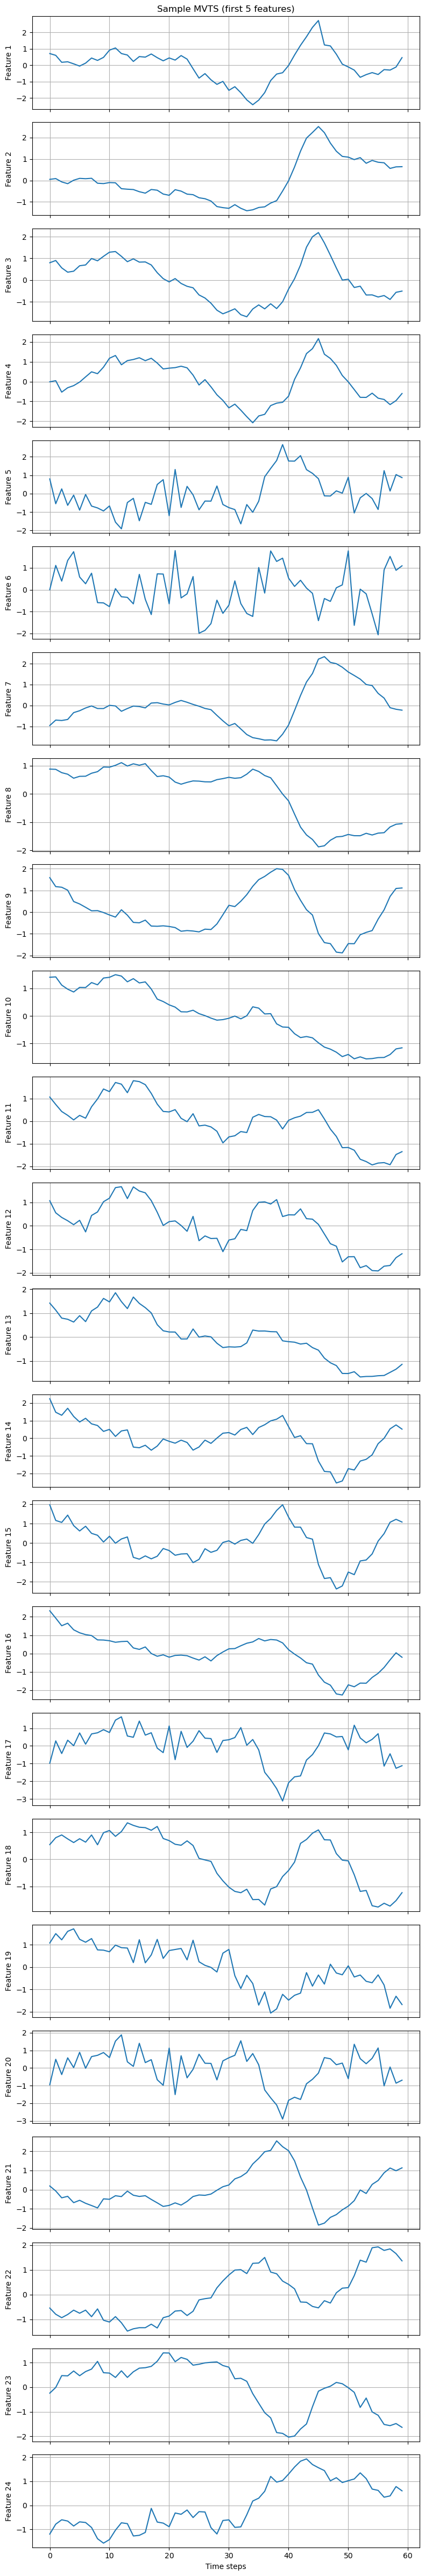

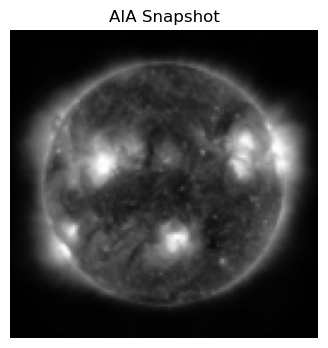

In [3]:
ts, img, label = dataset_P1[22]

print(f"Label: {label.item()}  (1 = FL, 0 = NF)")
print(f"Time series shape: {ts.shape}  (timesteps, features)")
print(f"Image shape: {img.shape}")

# --- Plot ---
# Plot each feature in its own subplot
num_features = min(50, ts.shape[1])  # visualize first 5 features
fig, axes = plt.subplots(num_features, 1, figsize=(8, 2 * num_features), sharex=True)

for i in range(num_features):
    axes[i].plot(ts[:, i].numpy())
    axes[i].set_ylabel(f"Feature {i+1}")
    axes[i].grid(True)

axes[0].set_title("Sample MVTS (first 5 features)")
axes[-1].set_xlabel("Time steps")
plt.tight_layout()
plt.show()

# --- Plot image ---
plt.figure(figsize=(4, 4))
plt.imshow(img[0], cmap="gray")
plt.title("AIA Snapshot")
plt.axis("off")
plt.show()


In [4]:
print(ts)

tensor([[ 0.7059,  0.0525,  0.7973,  ..., -0.5411, -0.2415, -1.1912],
        [ 0.5976,  0.0891,  0.9001,  ..., -0.7914, -0.0112, -0.7793],
        [ 0.1734, -0.0663,  0.5609,  ..., -0.9304,  0.4707, -0.5974],
        ...,
        [-0.2998,  0.5630, -0.8949,  ...,  1.8490, -1.5638,  0.3938],
        [-0.1145,  0.6356, -0.5660,  ...,  1.6582, -1.4781,  0.7830],
        [ 0.4587,  0.6436, -0.5096,  ...,  1.3659, -1.6319,  0.6053]])


# FRAMEWORK DOUBLE-T CONTRAST

In [58]:
from transformers import ViTModel, AutoImageProcessor
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageTransformerEncoder(nn.Module):
    def __init__(self, feature_dim=128, model_name="google/vit-base-patch16-224-in21k"):
        super().__init__()
        # Pretrained ViT
        self.vit = ViTModel.from_pretrained(model_name)
        
        # Projection head for contrastive learning
        self.proj_head = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, feature_dim)
        )
    
    def forward(self, x):
        """
        x: (B, 3, 224, 224) float tensor, normalized with ImageNet stats
        """
        outputs = self.vit(x).pooler_output  # CLS token embedding
        z = self.proj_head(outputs)
        z = F.normalize(z, dim=1)           # normalize for contrastive learning
        return z

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===========================
# Time Series Transformer Encoder
# ===========================
class TimeSeriesTransformerEncoder(nn.Module):
    def __init__(self, input_dim=24, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1, ff_dim=256):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        # x: (batch, T, F)
        x = self.input_proj(x)  # -> (B, T, embed_dim)
        x = self.transformer(x)  # (B, T, embed_dim)
        x_pooled = self.pool(x.permute(0, 2, 1)).squeeze(-1)  # (B, embed_dim)
        z = self.proj(x_pooled)
        return F.normalize(z, dim=1)

In [60]:
class TinyCrossAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        # Projection layers (tiny)
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)

        # LEARNABLE TEMPERATURE τ
        # Initialized to 1.0 but updated during training
        self.tau = nn.Parameter(torch.tensor(1.0))

    def forward(self, z_ts, z_img):
        # Input: (B, D)
        Q = self.W_q(z_ts)
        K = self.W_k(z_img)
        V = self.W_v(z_img)

        # Dot-product attention score
        raw_score = (Q * K).sum(dim=-1, keepdim=True)

        # Temperature scaling using learnable τ
        logits = raw_score / (self.tau + 1e-6)

        # Softmax (but with 1 element → acts as a learned weight)
        attn = torch.softmax(logits, dim=1)

        # Fused vector
        z_fused = Q + attn * V

        return z_fused, attn


In [61]:
class SupervisedContrastiveModel(nn.Module):
    def __init__(self, ts_dim=24, img_channels=1, patch_size=4, feature_dim=128, num_classes=2):
        super().__init__()

        self.encoder_ts = TimeSeriesTransformerEncoder()
        self.encoder_img = ImageTransformerEncoder()
        self.fusion = TinyCrossAttention(embed_dim=128)
        self.classifier = nn.Linear(128, num_classes)

        self.log_alpha = nn.Parameter(torch.tensor(0.0))   
        self.log_beta  = nn.Parameter(torch.tensor(-2.0))  

    def forward(self, ts, img):
        z_ts = self.encoder_ts(ts)
        z_img = self.encoder_img(img)
        z_fused, attn = self.fusion(z_ts, z_img)
        logits = self.classifier(z_fused)

        return z_ts, z_img, logits


In [62]:
import torch
import torch.nn.functional as F

def supervised_contrastive_loss(z1, z2, labels, temperature=0.5, eps=1e-8):
    """
    Robust supervised contrastive loss for a batch of embeddings.
    
    z1, z2 : torch.Tensor
        Embeddings from two modalities (B, D)
    labels : torch.Tensor
        Ground-truth labels (B,)
    temperature : float
        Scaling factor for similarity
    """
    # Normalize embeddings
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    
    # Concatenate embeddings
    z = torch.cat([z1, z2], dim=0)  # (2B, D)
    labels = torch.cat([labels, labels], dim=0)  # (2B,)
    
    # Cosine similarity
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / temperature  # (2B, 2B)
    
    # Mask: positives are same class, exclude self
    mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()
    mask.fill_diagonal_(0)  # remove self-similarity
    
    # Numerator: sum of exp(sim) over positive pairs
    numerator = (torch.exp(sim) * mask).sum(dim=1)
    
    # Denominator: sum of exp(sim) over all pairs except self
    denominator = (torch.exp(sim) * (1 - torch.eye(z.size(0), device=z.device))).sum(dim=1)
    
    # Compute loss safely
    loss = -torch.log(torch.clamp(numerator / (denominator + eps), min=1e-8))
    return loss.mean()


# Train-Test Modules

In [63]:
def train_model(dataset, epochs=10, batch_size=8, lr=1e-4, device='cuda'):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = SupervisedContrastiveModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ce_loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for ts, img, label in dataloader:
            ts, img, label = ts.to(device), img.to(device), label.to(device)

            # Forward pass
            z_ts, z_img, logits = model(ts, img)

            # Compute losses
            loss_con = supervised_contrastive_loss(z_ts, z_img, label)
            loss_cls = ce_loss_fn(logits, label)

            # use LEARNABLE weights α and β
            loss = model.alpha * loss_cls + model.beta * loss_con

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}]  Total Loss: {total_loss/len(dataloader):.4f}")
        print(f"  α (CE weight):  {model.alpha.item():.4f}")
        print(f"  β (CON weight): {model.beta.item():.4f}")

    return model

In [64]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

def train_model(dataset, epochs=10, batch_size=8, lr=1e-4, device='cuda'):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = SupervisedContrastiveModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ce_loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for ts, img, label in dataloader:
            ts, img, label = ts.to(device), img.to(device), label.to(device)

            # Forward pass
            z_ts, z_img, logits = model(ts, img)

            # Compute losses
            loss_con = supervised_contrastive_loss(z_ts, z_img, label)
            loss_cls = ce_loss_fn(logits, label)

            # Learnable weights α and β (ensure >0)
            alpha = torch.nn.functional.softplus(model.log_alpha)
            beta  = torch.nn.functional.softplus(model.log_beta)
            loss = alpha * loss_cls + beta * loss_con

            # Backprop
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            total_loss += loss.item()

        # Epoch logging
        print(f"Epoch [{epoch+1}/{epochs}]  Total Loss: {total_loss/len(dataloader):.4f}")
        print(f"  α (CE weight):  {alpha.item():.4f}")
        print(f"  β (CON weight): {beta.item():.4f}")

    return model


In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

@torch.no_grad()
def evaluate_model(model, dataset, batch_size=8, device='cuda'):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_labels = []
    all_preds = []
    all_probs = []

    for ts, img, label in dataloader:
        ts, img, label = ts.to(device), img.to(device), label.to(device)
        _, _, logits = model(ts, img)
        probs = torch.softmax(logits, dim=1)[:, 1]  # probability of FL class
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(label.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print("\n Evaluation Results")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NF", "FL"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix", fontweight='bold')
    plt.show()

    return {"acc": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc}


# TRAIN-TEST

# S2-S3

In [13]:
# ===========================
# Datasets
# ===========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # ensures 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = SWANMultimodalDataset(BASE_DIR, partition="partition2", transform=transform)
test_dataset = SWANMultimodalDataset(BASE_DIR, partition="partition3", transform=transform)

In [14]:
batch_size = 4  # small batch for testing
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize model
model = SupervisedContrastiveModel().to(device)
ce_loss_fn = nn.CrossEntropyLoss()

# Get a single batch
ts_batch, img_batch, label_batch = next(iter(dataloader))
ts_batch, img_batch, label_batch = ts_batch.to(device), img_batch.to(device), label_batch.to(device)

# Forward pass
z_ts, z_img, logits = model(ts_batch, img_batch)

# Compute losses
loss_con = supervised_contrastive_loss(z_ts, z_img, label_batch)
loss_cls = ce_loss_fn(logits, label_batch)
total_loss = loss_cls + 0.1 * loss_con

print(f"Forward pass works!")
print(f"Contrastive loss: {loss_con.item():.4f}")
print(f"Cross-entropy loss: {loss_cls.item():.4f}")

Forward pass works!
Contrastive loss: 1.0199
Cross-entropy loss: 0.6932


In [15]:
# ===========================
# 2️⃣  Train
# ===========================
model = train_model(
    train_dataset,
    epochs=7,
    batch_size=8,
    lr=1e-4,
    device='cpu'  # switch to 'cuda' if GPU is available
)

Epoch [1/7]  Total Loss: 0.4185
  α (CE weight):  0.6816
  β (CON weight): 0.1239
Epoch [2/7]  Total Loss: 0.2227
  α (CE weight):  0.6743
  β (CON weight): 0.1210
Epoch [3/7]  Total Loss: 0.1828
  α (CE weight):  0.6678
  β (CON weight): 0.1181
Epoch [4/7]  Total Loss: 0.1488
  α (CE weight):  0.6623
  β (CON weight): 0.1153
Epoch [5/7]  Total Loss: 0.1291
  α (CE weight):  0.6574
  β (CON weight): 0.1125
Epoch [6/7]  Total Loss: 0.1184
  α (CE weight):  0.6524
  β (CON weight): 0.1098
Epoch [7/7]  Total Loss: 0.0966
  α (CE weight):  0.6489
  β (CON weight): 0.1072



 Evaluation Results
Accuracy:  0.8622
Precision: 0.9674
Recall:    0.8532
F1 Score:  0.9067
ROC AUC:   0.9447


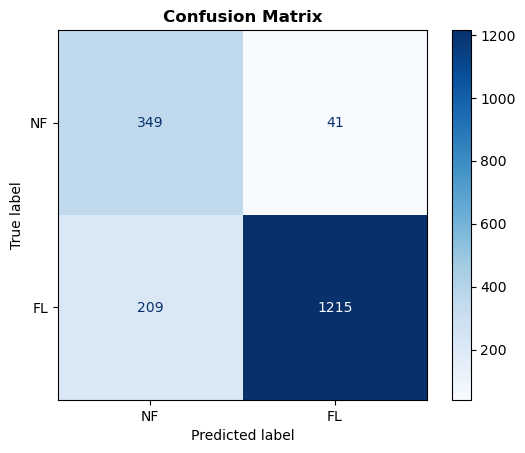

In [16]:
# ===========================
# 3️⃣  Evaluate
# ===========================
metrics = evaluate_model(
    model,
    test_dataset,
    batch_size=8,
    device='cpu'  # switch to 'cuda' if GPU is available
)

In [18]:
import os
import torch

# Create folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the entire model
torch.save(model.state_dict(), "models/V2supervised_contrastiveDoubleT_modelP2P3.pth")

print("✅ Model saved to models/V2supervised_contrastiveDoubleT_modelP2P3.pth")

✅ Model saved to models/V2supervised_contrastiveDoubleT_modelP2P3.pth


# S3-S4

In [19]:
# ===========================
# Datasets
# ===========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # ensures 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = SWANMultimodalDataset(BASE_DIR, partition="partition3", transform=transform)
test_dataset = SWANMultimodalDataset(BASE_DIR, partition="partition4", transform=transform)

In [20]:
# ===========================
# Train
# ===========================
model = train_model(
    train_dataset,
    epochs=7,
    batch_size=8,
    lr=1e-4,
    device='cpu'  # switch to 'cuda' if GPU is available
)

Epoch [1/7]  Total Loss: 0.3653
  α (CE weight):  0.6841
  β (CON weight): 0.1247
Epoch [2/7]  Total Loss: 0.2218
  α (CE weight):  0.6775
  β (CON weight): 0.1225
Epoch [3/7]  Total Loss: 0.1746
  α (CE weight):  0.6720
  β (CON weight): 0.1203
Epoch [4/7]  Total Loss: 0.1451
  α (CE weight):  0.6672
  β (CON weight): 0.1181
Epoch [5/7]  Total Loss: 0.1285
  α (CE weight):  0.6629
  β (CON weight): 0.1160
Epoch [6/7]  Total Loss: 0.1074
  α (CE weight):  0.6593
  β (CON weight): 0.1139
Epoch [7/7]  Total Loss: 0.1053
  α (CE weight):  0.6555
  β (CON weight): 0.1119



 Evaluation Results
Accuracy:  0.8803
Precision: 0.9584
Recall:    0.8695
F1 Score:  0.9118
ROC AUC:   0.9606


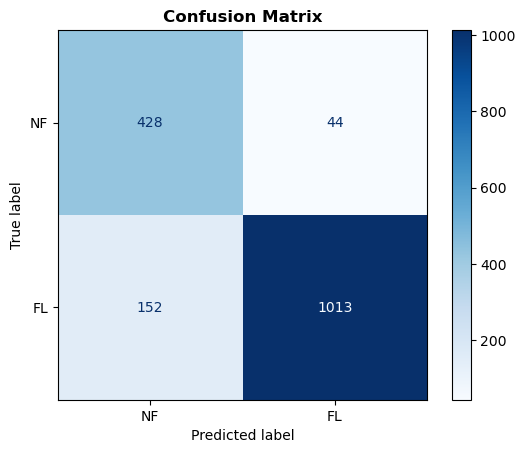

In [21]:
# ===========================
# 3️⃣  Evaluate
# ===========================
metrics = evaluate_model(
    model,
    test_dataset,
    batch_size=8,
    device='cpu'  # switch to 'cuda' if GPU is available
)

In [22]:
import os
import torch

# Create folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the entire model
torch.save(model.state_dict(), "models/V2supervised_contrastiveDoubleT_modelP3P4.pth")

print("✅ Model saved to models/V2supervised_contrastiveDoubleT_modelP3P4.pth")

✅ Model saved to models/V2supervised_contrastiveDoubleT_modelP3P4.pth


# S4-S5

In [23]:
# ===========================
# Datasets
# ===========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # ensures 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = SWANMultimodalDataset(BASE_DIR, partition="partition4", transform=transform)
test_dataset = SWANMultimodalDataset(BASE_DIR, partition="partition5", transform=transform)

In [24]:
# ===========================
# Train
# ===========================
model = train_model(
    train_dataset,
    epochs=7,
    batch_size=8,
    lr=1e-4,
    device='cpu'  # switch to 'cuda' if GPU is available
)

Epoch [1/7]  Total Loss: 0.3903
  α (CE weight):  0.6849
  β (CON weight): 0.1248
Epoch [2/7]  Total Loss: 0.1810
  α (CE weight):  0.6807
  β (CON weight): 0.1227
Epoch [3/7]  Total Loss: 0.1309
  α (CE weight):  0.6774
  β (CON weight): 0.1207
Epoch [4/7]  Total Loss: 0.1062
  α (CE weight):  0.6748
  β (CON weight): 0.1186
Epoch [5/7]  Total Loss: 0.0942
  α (CE weight):  0.6724
  β (CON weight): 0.1167
Epoch [6/7]  Total Loss: 0.0824
  α (CE weight):  0.6705
  β (CON weight): 0.1147
Epoch [7/7]  Total Loss: 0.0741
  α (CE weight):  0.6688
  β (CON weight): 0.1128



 Evaluation Results
Accuracy:  0.8164
Precision: 0.9261
Recall:    0.7343
F1 Score:  0.8192
ROC AUC:   0.9367


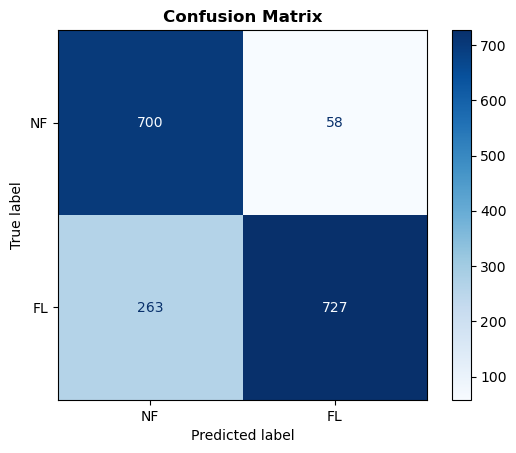

In [25]:
# ===========================
# 3️⃣  Evaluate
# ===========================
metrics = evaluate_model(
    model,
    test_dataset,
    batch_size=8,
    device='cpu'  # switch to 'cuda' if GPU is available
)

In [26]:
import os
import torch

# Create folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the entire model
torch.save(model.state_dict(), "models/V2supervised_contrastiveDoubleT_modelP4P5.pth")

print("✅ Model saved to models/V2supervised_contrastiveDoubleT_modelP4P5.pth")

✅ Model saved to models/V2supervised_contrastiveDoubleT_modelP4P5.pth
